<a href="https://colab.research.google.com/github/Usool-Data-Science/TensorFlow-Examples/blob/master/Spectroscopy%20data%20regression%20with%20transfer%20learning%20approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectroscopy data regression with transfer learning approach

## Import libraries

In [ ]:
pip install -q -U keras-tuner

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D,Flatten,Dense,Dropout
import keras_tuner as kt
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras_tuner import RandomSearch, BayesianOptimization, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

# Plot pretrained model

In [ ]:
model_path =  "/content/gdrive/MyDrive/best_model.h5"

In [ ]:
pretrained_model = load_model(model_path)

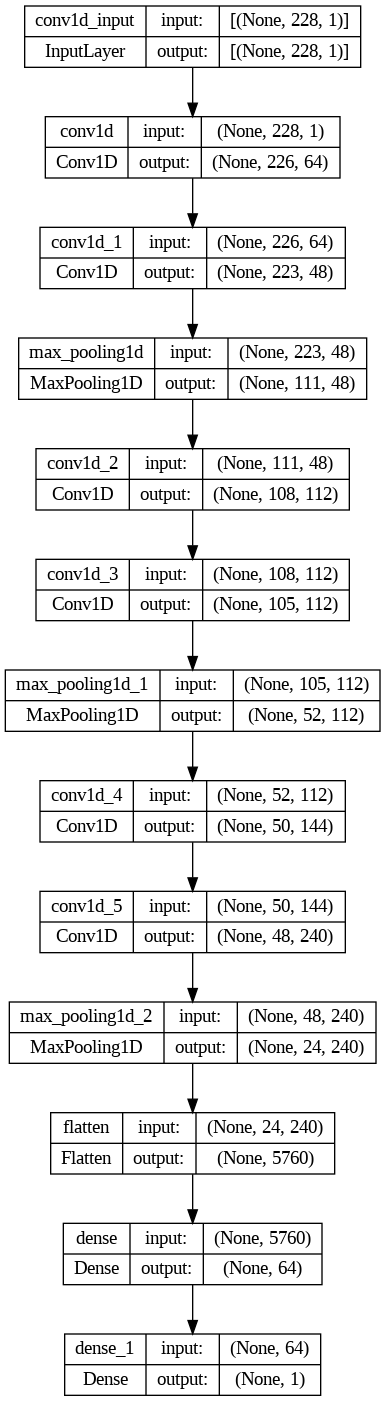

In [ ]:
plot_model(pretrained_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Obtain the dataset

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
datasets_path = "/content/gdrive/MyDrive/Regression data folder"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Mango dataset

In [ ]:
mango_path = datasets_path + "/mango.xlsx"
mango_df = pd.read_excel(mango_path)
mango_df.head()

,Sample,Type,Y,900.906296,904.828517,908.74643,913.963613,917.871475,921.775029,925.674276,...,1673.869441,1676.82389,1679.774032,1682.719866,1685.661393,1688.598612,1691.531523,1695.435371,1698.358232,1701.276785
0,1,Chokonan,9.3,0.319788,0.342308,0.335639,0.343268,0.337038,0.339890,0.343685,...,0.672983,0.647243,0.662255,0.646850,0.645762,0.637481,0.637639,0.663365,0.619574,0.633781
1,2,Chokonan,9.5,0.364814,0.370077,0.367969,0.369791,0.369364,0.370192,0.372791,...,0.643948,0.638020,0.637085,0.632175,0.640861,0.635411,0.637604,0.657138,0.649134,0.666103
2,3,Chokonan,9.6,0.382788,0.371731,0.379194,0.377878,0.385684,0.382643,0.384463,...,0.709818,0.707299,0.691883,0.693232,0.695195,0.708563,0.712421,0.728612,0.708679,0.721926
3,4,Chokonan,9.8,0.396310,0.410002,0.401343,0.405011,0.397548,0.407203,0.409507,...,0.637108,0.624327,0.617880,0.616653,0.600407,0.580193,0.628275,0.628518,0.711261,0.620656
4,5,Chokonan,13.6,0.508116,0.511388,0.516169,0.516697,0.518855,0.517045,0.522757,...,0.701061,0.687959,0.673802,0.677426,0.673019,0.676707,0.685695,0.700445,0.677998,0.678265


In [ ]:
mango_Y = mango_df.values[:,2]
mango_X = mango_df.values[:,3:]

#### Plot graph

General function to plot graph

In [ ]:
def plot_spectral(x,y,title,save_name):
  fig = plt.figure(figsize=(10,7))
  plt.title(title)
  plt.xlabel("Wavelength (nm)")
  plt.ylabel ("Absorbance (Au)")
  for i in range (len(y)):
    plt.plot(x,y[i])

  fig.savefig(f'{save_name}.jpg', dpi=250)

In [ ]:
mango_x = mango_df.columns [3:]
mango_y = mango_df.values[:,3:].astype(float)

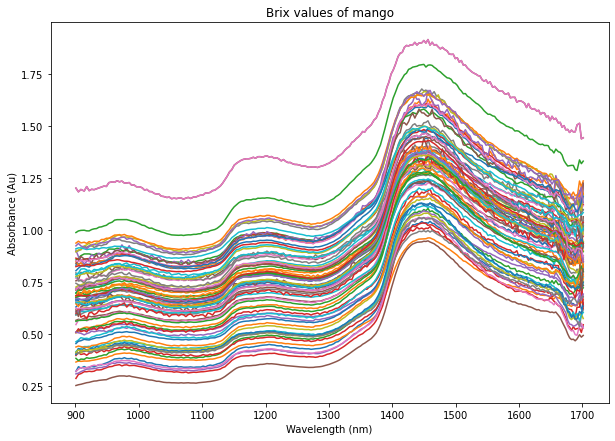

In [ ]:
plot_spectral(mango_x,mango_y,"Brix values of mango","Mango")

#### Preparation of training and testing dataset

In [ ]:
mango_X = mango_X.astype("float32")
mango_Y = mango_Y.astype("float32")

In [ ]:
mango_Xtrain,mango_Xtest,mango_Ytrain,mango_Ytest = train_test_split(mango_X,mango_Y,test_size = 0.2,random_state = 0)

In [ ]:
mango_Xtrain.shape

(64, 228)

#### Model preparation

In [ ]:
def build_model(hp):
  model = keras.Sequential([
      Conv1D(
          filters= hp.Int("conv1_filter",min_value=16,max_value=128,step=16),
          kernel_size=hp.Choice("conv1_kernelsize",values=[3,4,5]),
          activation="relu",
          input_shape=(mango_Xtrain.shape[1],1)
      ),
      Conv1D(
          filters= hp.Int("conv2_filter",min_value=16,max_value=128,step=16),
          kernel_size=hp.Choice("conv2_kernelsize",values=[3,4,5]),
          activation="relu",
    
      ),

      MaxPooling1D(2),
      Conv1D(
          filters= hp.Int("conv3_filter",min_value=32,max_value=128,step=16),
          kernel_size=hp.Choice("conv3_kernelsize",values=[3,4,5]),
          activation="relu"
      ),
      Conv1D(
          filters= hp.Int("conv4_filter",min_value=32,max_value=128,step=16),
          kernel_size=hp.Choice("conv4_kernelsize",values=[3,4,5]),
          activation="relu"
      ),
      MaxPooling1D(2),
      Conv1D(
          filters= hp.Int("conv5_filter",min_value=64,max_value=256,step=16),
          kernel_size=hp.Choice("conv5_kernelsize",values=[3,4,5]),
          activation="relu"
      ),
      Conv1D(
          filters= hp.Int("conv6_filter",min_value=64,max_value=256,step=16),
          kernel_size=hp.Choice("conv6_kernelsize",values=[3,4,5]),
          activation="relu"
      ),
      MaxPooling1D(2),
      Flatten(),
      Dense(
          units=hp.Int("dense1_units",min_value=16,max_value=128,step=16),
          activation="relu"
      ),
      Dense(1,activation="linear")
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate",values=[1e-2,1e-3])),loss='mean_squared_error')

  return model

In [ ]:
tuner_search=Hyperband(build_model,
                          objective='val_loss',overwrite=True,
                          max_epochs=50,directory='output1',project_name="Pretrained model")

In [ ]:
tuner_search.search(mango_Xtrain, mango_Ytrain, epochs=500, validation_split=0.2)
best_model = tuner_search.get_best_models()[0]

Trial 90 Complete [00h 00m 16s]
val_loss: 0.31601816415786743

Best val_loss So Far: 0.23902970552444458
Total elapsed time: 00h 05m 56s


In [ ]:
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 226, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 223, 48)           12336     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 111, 48)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 108, 112)          21616     
                                                                 
 conv1d_3 (Conv1D)           (None, 105, 112)          50288     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 112)          0         
 1D)                                                    

In [ ]:
best_model.fit(mango_Xtrain,mango_Ytrain,validation_split=0.2,epochs=10)

Epoch 1/10
2/2 [==============================] - 1s 294ms/step - loss: 0.5337 - val_loss: 0.3030
Epoch 2/10
2/2 [==============================] - 0s 98ms/step - loss: 0.5285 - val_loss: 1.7731
Epoch 3/10
2/2 [==============================] - 0s 93ms/step - loss: 0.7232 - val_loss: 0.5654
Epoch 4/10
2/2 [==============================] - 0s 92ms/step - loss: 0.5100 - val_loss: 0.7725
Epoch 5/10
2/2 [==============================] - 0s 99ms/step - loss: 0.4955 - val_loss: 1.2271
Epoch 6/10
2/2 [==============================] - 0s 96ms/step - loss: 0.6009 - val_loss: 0.9595
Epoch 7/10
2/2 [==============================] - 0s 98ms/step - loss: 0.4426 - val_loss: 1.4748
Epoch 8/10
2/2 [==============================] - 0s 91ms/step - loss: 0.5082 - val_loss: 0.7727
Epoch 9/10
2/2 [==============================] - 0s 98ms/step - loss: 0.4280 - val_loss: 0.8894
Epoch 10/10
2/2 [==============================] - 0s 94ms/step - loss: 0.4918 - val_loss: 0.6666


In [ ]:
eval_result = best_model.evaluate(mango_Xtest,mango_Ytest)
print("Test loss:", eval_result)

1/1 [==============================] - 0s 35ms/step - loss: 0.3146
Test loss: 0.3145688772201538


In [ ]:
best_model.save("best_model.h5")

### Tablet dataset


In [ ]:
tablet_path = datasets_path + "/Tablet.xlsx"
tablet_df = pd.read_excel(tablet_path)
tablet_df.head()

,Y,Type,Scale,7398.337,7406.051,7413.766,7421.481,7429.195,7436.91,7444.624,...,10437.87,10445.59,10453.3,10461.02,10468.73,10476.45,10484.16,10491.88,10499.59,10507.3
0,5.479603,1,0,1.314189,1.251776,1.191130,1.133382,1.080259,1.031387,0.986337,...,-0.114345,-0.117849,-0.121483,-0.124510,-0.126171,-0.124901,-0.125070,-0.129110,-0.132152,-0.130857
1,5.482797,1,0,1.418517,1.354198,1.292556,1.233600,1.179345,1.129443,1.083619,...,-0.050702,-0.053399,-0.056890,-0.059346,-0.060028,-0.058698,-0.060552,-0.066295,-0.069032,-0.066877
2,5.477778,1,0,1.599241,1.532634,1.469086,1.407317,1.350641,1.298261,1.249429,...,0.022408,0.019277,0.015504,0.012248,0.011139,0.012459,0.010324,0.004168,0.001039,0.003172
3,5.384615,1,0,1.339236,1.277382,1.217709,1.160600,1.108079,1.059867,1.015320,...,-0.076847,-0.080041,-0.083451,-0.085780,-0.086316,-0.084981,-0.086594,-0.091895,-0.094733,-0.093018
4,5.373134,1,0,1.493325,1.429678,1.368466,1.309522,1.254920,1.204737,1.158200,...,-0.000099,-0.003130,-0.006159,-0.009153,-0.010739,-0.009463,-0.011218,-0.016961,-0.019661,-0.017702


In [ ]:
tablet_Xdf =pd.DataFrame(tablet_df.values[:,3:])
tablet_Xdf.columns=tablet_df.columns[3:]

In [ ]:
tablet_Xdf.head()

,7398.337,7406.051,7413.766,7421.481,7429.195,7436.910,7444.624,7452.339,7460.053,7467.768,...,10437.870,10445.590,10453.300,10461.020,10468.730,10476.450,10484.160,10491.880,10499.590,10507.300
0,1.314189,1.251776,1.191130,1.133382,1.080259,1.031387,0.986337,0.945453,0.907986,0.872446,...,-0.114345,-0.117849,-0.121483,-0.124510,-0.126171,-0.124901,-0.125070,-0.129110,-0.132152,-0.130857
1,1.418517,1.354198,1.292556,1.233600,1.179345,1.129443,1.083619,1.041672,1.002716,0.966060,...,-0.050702,-0.053399,-0.056890,-0.059346,-0.060028,-0.058698,-0.060552,-0.066295,-0.069032,-0.066877
2,1.599241,1.532634,1.469086,1.407317,1.350641,1.298261,1.249429,1.205471,1.165011,1.125740,...,0.022408,0.019277,0.015504,0.012248,0.011139,0.012459,0.010324,0.004168,0.001039,0.003172
3,1.339236,1.277382,1.217709,1.160600,1.108079,1.059867,1.015320,0.974589,0.936828,0.901571,...,-0.076847,-0.080041,-0.083451,-0.085780,-0.086316,-0.084981,-0.086594,-0.091895,-0.094733,-0.093018
4,1.493325,1.429678,1.368466,1.309522,1.254920,1.204737,1.158200,1.115872,1.077138,1.040555,...,-0.000099,-0.003130,-0.006159,-0.009153,-0.010739,-0.009463,-0.011218,-0.016961,-0.019661,-0.017702


Take only 228 wavelengths for each sample in order to match the input size of the model


In [ ]:
sample_df_columns = tablet_Xdf.sample(228,axis=1).columns

In [ ]:
sample_df_columns

Index([8138.935, 8779.243, 8192.937, 10260.44, 9226.688, 7676.061, 7544.913,
       9913.283, 8547.806, 8054.074,
       ...
       8424.373, 8987.536, 8362.657, 9990.429,  8740.67, 7722.348, 10337.58,
        7776.35, 7853.496, 7622.059],
      dtype='object', length=228)

In [ ]:
arr =np.array(sample_df_columns)
sorted_arr = np.sort(arr)

In [ ]:
tablet_Xdf = tablet_Xdf[sorted_arr]

In [ ]:
tablet_Xdf.head()

,7398.337,7413.766,7421.481,7436.910,7444.624,7452.339,7460.053,7467.768,7475.482,7490.912,...,10422.440,10430.160,10437.870,10445.590,10453.300,10468.730,10484.160,10491.880,10499.590,10507.300
0,1.314189,1.191130,1.133382,1.031387,0.986337,0.945453,0.907986,0.872446,0.838224,0.774104,...,-0.105980,-0.110468,-0.114345,-0.117849,-0.121483,-0.126171,-0.125070,-0.129110,-0.132152,-0.130857
1,1.418517,1.292556,1.233600,1.129443,1.083619,1.041672,1.002716,0.966060,0.931150,0.865744,...,-0.042697,-0.047515,-0.050702,-0.053399,-0.056890,-0.060028,-0.060552,-0.066295,-0.069032,-0.066877
2,1.599241,1.469086,1.407317,1.298261,1.249429,1.205471,1.165011,1.125740,1.087722,1.018609,...,0.031132,0.026230,0.022408,0.019277,0.015504,0.011139,0.010324,0.004168,0.001039,0.003172
3,1.339236,1.217709,1.160600,1.059867,1.015320,0.974589,0.936828,0.901571,0.868274,0.804947,...,-0.069024,-0.073092,-0.076847,-0.080041,-0.083451,-0.086316,-0.086594,-0.091895,-0.094733,-0.093018
4,1.493325,1.368466,1.309522,1.204737,1.158200,1.115872,1.077138,1.040555,1.005629,0.939530,...,0.008977,0.004097,-0.000099,-0.003130,-0.006159,-0.010739,-0.011218,-0.016961,-0.019661,-0.017702


In [ ]:
tablet_X = tablet_Xdf.values
tablet_Y = tablet_df.values[:,0]

In [ ]:
tablet_X = tablet_X.astype("float32")
tablet_Y = tablet_Y.astype("float32")

In [ ]:
tablet_Y.shape

(310,)

ValueError: ignored

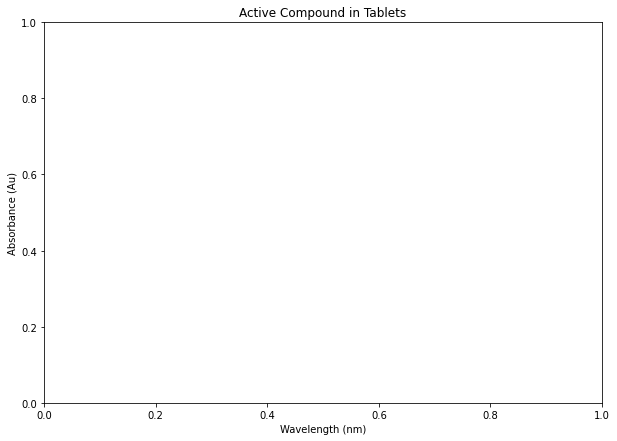

In [ ]:
plot_spectral(tablet_X,tablet_Y,"Active Compound in Tablets","Tablet")

In [ ]:
tablet_Xtrain,tablet_Xtest,tablet_Ytrain,tablet_Ytest = train_test_split(tablet_X,tablet_Y,test_size = 0.2,random_state = 0)

#### Load the pretrained model

In [ ]:
tablet_model = load_model(model_path)

In [ ]:
tablet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 226, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 223, 48)           12336     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 111, 48)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 108, 112)          21616     
                                                                 
 conv1d_3 (Conv1D)           (None, 105, 112)          50288     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 52, 112)          0         
 1D)                                                    

#### Freezing and training of pretrained model

Only the last two layers can be trained while the others are freezed

In [ ]:
for i in range(6):
  tablet_model.layers[i].trainable=False

for i in range(6,12):
  tablet_model.layers[i].trainable=True

In [ ]:
tablet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
history_tablet=tablet_model.fit(tablet_Xtrain,tablet_Ytrain, validation_split=0.2,epochs=30, batch_size=32)

Epoch 1/30
7/7 [==============================] - 1s 98ms/step - loss: 22.9756 - val_loss: 3.3450
Epoch 2/30
7/7 [==============================] - 0s 55ms/step - loss: 7.4776 - val_loss: 5.1359
Epoch 3/30
7/7 [==============================] - 0s 57ms/step - loss: 4.5114 - val_loss: 3.7266
Epoch 4/30
7/7 [==============================] - 0s 59ms/step - loss: 2.7758 - val_loss: 2.8141
Epoch 5/30
7/7 [==============================] - 0s 60ms/step - loss: 2.3355 - val_loss: 2.7401
Epoch 6/30
7/7 [==============================] - 0s 62ms/step - loss: 1.9956 - val_loss: 1.8761
Epoch 7/30
7/7 [==============================] - 0s 56ms/step - loss: 1.7638 - val_loss: 2.1572
Epoch 8/30
7/7 [==============================] - 0s 57ms/step - loss: 1.9238 - val_loss: 1.6779
Epoch 9/30
7/7 [==============================] - 0s 60ms/step - loss: 1.7021 - val_loss: 1.4509
Epoch 10/30
7/7 [==============================] - 0s 58ms/step - loss: 1.4720 - val_loss: 1.4053
Epoch 11/30
7/7 [===========

In [ ]:
tablet_result = tablet_model.evaluate(tablet_Xtest,tablet_Ytest)
print(f"Tablet dataset test loss:{tablet_result}")

2/2 [==============================] - 0s 25ms/step - loss: 1.4399
Tablet dataset test loss:1.4398725032806396


#### Obtained the result of tablet dataset

In [ ]:
predicted_result = []
for i in range(len(tablet_Xtest)):
  predicted_result.append(tablet_model.predict(np.expand_dims(tablet_X[i],0))[0][0])


1/1 [==============================] - 0s 21ms/step


# Plot scatter plot

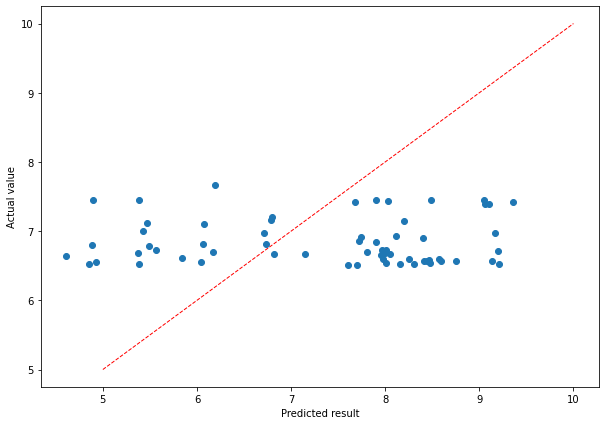

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(5,10,10)
y=x
plt.figure(figsize=(10,7))
plt.plot(x,y,color='red',linewidth=1.0,linestyle='--',label='line')
plt.scatter(tablet_Ytest,predicted_result)
plt.xlabel("Predicted result")
plt.ylabel("Actual value")
plt.show()

In [ ]:
from sklearn.metrics import r2_score

r2_score(tablet_Ytest, predicted_result)

-0.19532870568367033

In [ ]:
def predict_regression(index):
  print("Predicted:",tablet_model.predict(np.expand_dims(tablet_Xtest[index],0))[0][0])
  print("Actual",tablet_Ytest[index])

In [ ]:
predict_regression(5)

#### Create a model from scratch 

In [ ]:
tablet_model_from_scratch = Sequential(
    [
        Conv1D(64, 3,input_shape=(228,1), activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(32, 3, activation='relu'),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(16, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(1, activation='linear')    
    ]
)


In [ ]:
tablet_model_from_scratch.compile(optimizer = tf.keras.optimizers.Adam(0.01),loss='mean_squared_error')
tablet_model_from_scratch.fit(tablet_Xtrain,tablet_Ytrain, validation_split=0.2,epochs=30, batch_size=32)

In [ ]:
tablet_result_from_scratch = tablet_model_from_scratch.evaluate(tablet_Xtest,tablet_Ytest)
print(f"Tablet dataset test loss:{tablet_result_from_scratch}")

### Grain moisture level dataset

In [ ]:
grain_path = datasets_path + "/grain_moisture.xlsx"
grain_df = pd.read_excel(grain_path)
grain_df.head()

In [ ]:
grain_Xdf =pd.DataFrame(grain_df.values[:,1:])
grain_Xdf.columns=grain_df.columns[1:]

In [ ]:
grain_Xdf.head()

In [ ]:
grain_sample_df_columns = grain_Xdf.sample(228,axis=1,replace="True").columns

In [ ]:
grain_sample_df_columns

In [ ]:
grain_arr =np.array(grain_sample_df_columns)
grain_sorted_arr = np.sort(grain_arr)

In [ ]:
tablet_Xdf = tablet_Xdf[sorted_arr]

grain_Xdf=grain_Xdf[grain_sorted_arr]

In [ ]:
grain_Xdf.head()

In [ ]:
grain_X = grain_Xdf.values
grain_Y = grain_df.values[:,0]

In [ ]:
graint_X = grain_X.astype("float32")
grain_Y = grain_Y.astype("float32")

In [ ]:
grain_Xtrain,grain_Xtest,grain_Ytrain,grain_Ytest = train_test_split(grain_X,grain_Y,test_size = 0.2,random_state = 0)

#### Load the pretrained model

In [ ]:
grain_model = load_model("model.h5")

In [ ]:
grain_model.summary()

#### Freezing and training of pretrained model

Only the last two layers can be trained while the others are freezed

In [ ]:
for i in range(6):
  grain_model.layers[i].trainable=False

for i in range(6,9):
  grain_model.layers[i].trainable=True

In [ ]:
grain_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
history_grain=grain_model.fit(grain_Xtrain,grain_Ytrain, validation_split=0.2,epochs=30, batch_size=32)

In [ ]:
grain_result = grain_model.evaluate(grain_Xtest,grain_Ytest)
print(f"Grain dataset test loss:{grain_result}")

#### Obtained the result of tablet dataset

In [ ]:
def predict_regression(index):
  print("Predicted:",grain_model.predict(np.expand_dims(grain_Xtest[index],0))[0][0])
  print("Actual",grain_Ytest[index])

In [ ]:
predict_regression(0)

#### Create a model from scratch 

In [ ]:
grain_model_from_scratch = Sequential(
    [
        Conv1D(64, 3,input_shape=(228,1), activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(3),
        Conv1D(32, 3, activation='relu'),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(16, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(1, activation='linear')    
    ]
)

In [ ]:
grain_model_from_scratch.compile(optimizer = tf.keras.optimizers.Adam(0.01),loss='mean_squared_error')
grain_model_from_scratch.fit(grain_Xtrain,grain_Ytrain, validation_split=0.2,epochs=30, batch_size=32)

In [ ]:
grain_result_from_scratch = grain_model_from_scratch.evaluate(grain_Xtest,grain_Ytest)
print(f"Grain dataset test loss:{grain_result_from_scratch}")

### Starch content in corn

In [ ]:
corn_path = datasets_path + "/corn_data.xlsx"
corn_df = pd.read_excel(corn_path)
corn_df.head()

In [ ]:
corn_Xdf =pd.DataFrame(corn_df.values[:,5:])
corn_Xdf.columns=corn_df.columns[5:]

In [ ]:
corn_Xdf.head()

In [ ]:
corn_sample_df_columns = corn_Xdf.sample(228,axis=1).columns

In [ ]:
corn_sample_df_columns

In [ ]:
corn_arr =np.array(corn_sample_df_columns)
corn_sorted_arr = np.sort(corn_arr)

In [ ]:
corn_Xdf = corn_Xdf[corn_sorted_arr]

In [ ]:
corn_Xdf.head()

In [ ]:
corn_X = corn_Xdf.values
corn_Y = corn_df.values[:,3]

In [ ]:
corn_X = corn_X.astype("float32")
corn_Y = corn_Y.astype("float32")

In [ ]:
corn_Xtrain,corn_Xtest,corn_Ytrain,corn_Ytest = train_test_split(corn_X,corn_Y,test_size = 0.2,random_state = 0)

#### Load the pretrained model

In [ ]:
corn_model = load_model("model.h5")

In [ ]:
corn_model.summary()

#### Freezing and training of pretrained model

Only the last two layers can be trained while the others are freezed

In [ ]:
for i in range(6):
  corn_model.layers[i].trainable=False

for i in range(6,9):
  corn_model.layers[i].trainable=True

In [ ]:
corn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
history_corn=corn_model.fit(corn_Xtrain,corn_Ytrain, validation_split=0.2,epochs=30, batch_size=32)

In [ ]:
corn_result = corn_model.evaluate(corn_Xtest,corn_Ytest)
print(f"Corn dataset test loss:{corn_result}")

#### Obtained the result of tablet dataset

In [ ]:
def predict_regression(index):
  print("Predicted:",corn_model.predict(np.expand_dims(corn_Xtest[index],0))[0][0])
  print("Actual",corn_Ytest[index])

In [ ]:
predict_regression(0)

#### Create a model from scratch 

In [ ]:
corn_model_from_scratch = Sequential(
    [
        Conv1D(64, 3,input_shape=(228,1), activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(3),
        Conv1D(32, 3, activation='relu'),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(16, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(1, activation='linear')    
    ]
)

In [ ]:
corn_model_from_scratch.compile(optimizer = tf.keras.optimizers.Adam(0.01),loss='mean_squared_error')
corn_model_from_scratch.fit(corn_Xtrain,corn_Ytrain, validation_split=0.2,epochs=30, batch_size=32)

In [ ]:
corn_result_from_scratch = corn_model_from_scratch.evaluate(corn_Xtest,corn_Ytest)
print(f"Corn dataset test loss:{corn_result_from_scratch}")